### Introduction

- A common problem in Marketing is how to attribute a sale to touchpoints.
- Before a customer makes a purchase, they usually first interact with multiple touchpoints (e.g. ads)

### Data Generation

In [114]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

In [115]:
N = 2000 # number of conversion paths
K = 5 # number of channels
MIN_TOUCHPOINTS = 3
MAX_TOUCHPOINTS = 7

channel_effectiveness = np.random.uniform(-1/K, 2/K, K) # randomly generate channel effectiveness
channels = np.arange(K) # channel indices

In [116]:
n_touchpoints = np.random.randint(MIN_TOUCHPOINTS, MAX_TOUCHPOINTS, size=N)

Text(0, 0.5, 'Effectiveness')

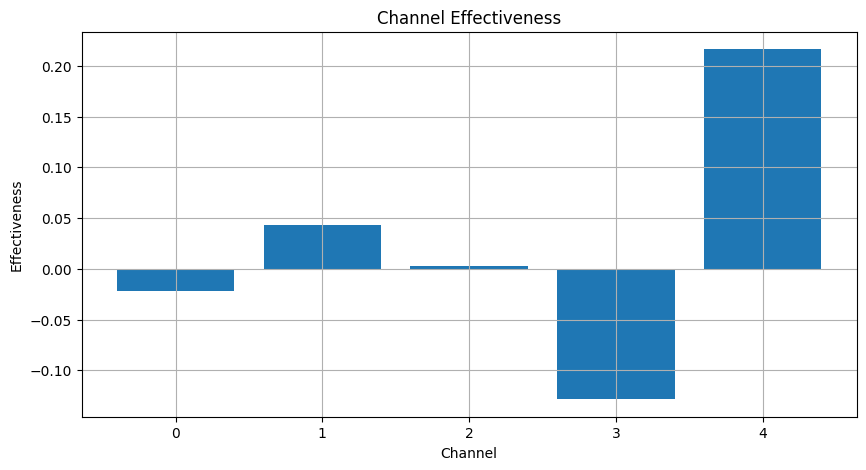

In [117]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.grid(True)
plt.bar(channels, channel_effectiveness)
plt.title('Channel Effectiveness')
plt.xlabel('Channel')
plt.ylabel('Effectiveness')

In [118]:
# n_touchpoints = np.random.randint(MIN_TOUCHPOINTS, MAX_TOUCHPOINTS, size=N)
data = []

base_conversion_rate = 0.1

for i in range(N):
    coalition = np.random.choice(a=channels, size=n_touchpoints[i], replace=True)
    unique_channels = np.unique(coalition)
    conv_prob = max(0,min(1.0,base_conversion_rate+np.sum(channel_effectiveness[unique_channels])))

    channel_present = {
        'channel_'+str(channel): 1 if channel in coalition else 0
        for channel in channels
    }

    path = {
        **channel_present,
        'coalition': unique_channels,
        'conversion_prob':  conv_prob,
        'last_touch': coalition[-1],
        'first_touch': coalition[0],
        'conversion': np.random.choice([0, 1], p=[1-conv_prob, conv_prob])
    }
    data.append(path)

In [119]:
df = pd.DataFrame(data)

In [120]:
attribution = df.iloc[:1500].groupby('first_touch').agg(
    conversion_rate=('conversion', 'mean'),
).reset_index()

attribution

,first_touch,conversion_rate
0,0,0.161094
1,1,0.154386
2,2,0.156863
3,3,0.111888
4,4,0.244898


In [125]:
merged = df.merge(attribution, on='first_touch', how='left')# [['conversion_prob', 'conversion_rate']].corr()

In [135]:
merged['pred'] = merged.conversion_rate.apply(lambda x: 1.0*(np.random.rand() < x))

In [139]:
acc = accuracy_score(merged.conversion, merged.pred)
recall = np.sum((merged.conversion == 1) & (merged.pred == 1)) / np.sum(merged.conversion == 1)

In [140]:
recall

0.18373493975903615

In [91]:
df.conversion.sum() / N

0.0985

In [88]:
df

,channel_0,channel_1,channel_2,channel_3,channel_4,coalition,conversion_prob,last_touch,first_touch,conversion
0,1,0,0,1,1,"[0, 3, 4]",0.000000,3,4,0
1,1,0,0,0,1,"[0, 4]",0.000000,0,4,0
2,1,1,0,1,0,"[0, 1, 3]",0.000000,0,3,0
3,0,1,0,1,1,"[1, 3, 4]",0.056386,4,3,0
4,1,0,1,0,1,"[0, 2, 4]",0.100476,4,2,0
...,...,...,...,...,...,...,...,...,...,...
1995,0,1,1,1,0,"[1, 2, 3]",0.239310,2,1,1
1996,1,1,1,1,1,"[0, 1, 2, 3, 4]",0.076871,4,2,0
1997,1,0,1,1,0,"[0, 2, 3]",0.088976,0,0,0
1998,1,1,1,1,0,"[0, 1, 2, 3]",0.096880,2,2,0


In [53]:

X_train, X_test, y_train, y_test = train_test_split(df[['channel_'+str(i) for i in channels]], df['conversion'], test_size=0.33, random_state=42)

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

0.7212121212121212

In [ ]:
# model the positional dependence with a negative binomial distribution

In [ ]:
nb = np.random.negative_binomial(1, 0.5, size=1000)
plt.hist(nb, bins=30)

In [73]:
df.groupby("last_touch").agg(
    channel_kpi=("KPI", lambda x: x.sum()/N),
    global_kpi=("KPI", lambda x: x.mean() - df.KPI.mean())
)

,channel_kpi,global_kpi
last_touch,,
0,0.137737,0.092550
1,0.122806,-0.018351
2,0.154852,0.040891
3,0.099168,-0.012580
4,0.117817,-0.096847


In [ ]:
def shapley(data:list):
    